# Een binaire klok

De microbit heeft een erg primitief display, van 5x5 LEDs.
Het lijkt onmogelijk om dat te gebruiken voor een klok die de tijd aangeeft in uren en minuten.
Maar door gebruik te maken van de binaire vorm van getallen lukt dat toch.

Uitgangspunt is de notatie van de tijd in de vorm: HH:MM:SS. De minuten en seconden lopen van 0 naar 59: die kunnen we niet in 5 bits weergeven; deze geven we daarom weer als twee (decimale) cijfers in binaire vorm. 59 wordt dan (00101, 01001). Alleen voor de uren gebruiken we de volledige binaire vorm: voor 0..23 hebben we voldoende aan 5 bits.

## Ophogen van de klok

Voor het representeren van de tijd gebruiken we 3 getallen: uren, minuten, seconden.

```Python
def next_second():
    global seconds, minutes, hours
    seconds = seconds + 1
    if seconds == 60:
        seconds = 0
        minutes = minutes + 1
        if minutes == 60:
            minutes = 0
            hours = (hours + 1) % 24
    display_time()
```

We gebruiken hierin de Python *modulo* operator: `%`. Deze geeft de rest na deling.
Als `hours < 24`, dan is `hours == hours % 24`. Als `hours == 24`, dan is `hours % 24 == 0`.


## Weergeven van de tijd

```Python
def display_time():
    global seconds, minutes, hours, 
    display_binary(4, seconds % 10)
    display_binary(3, seconds / 10)
    display_binary(2, minutes % 10)
    display_binary(1, minutes / 10)
    display_binary(0, hours)

def display_binary(col, nr):
    for i in range(5):
        display.set_pixel(col, i, nr % 2)
        nr = nr // 2
```

```Python
display.set_pixel(0,0,9)
display.set_pixel(1,2,9)
sleep(5000)
hours, minutes, seconds = 10, 20, 30
display_time()
sleep(5000)
hours, minutes, seconds = 12, 34, 56
display_time()
sleep(1000)
```

```Python
hours, minutes, seconds = 0, 0, 0
display_time()
while True:
    if utime.ticks_ms() % 1000 == 0:
        next_second()
```

Eigenlijk moeten we hier met een timer werken.

De volgende stap is het gebruik van de drukknoppen om de klok in te stellen.
We werken met de volgende toestanden:

* running
* set kolom 0
* set kolom 1
* set kolom 2
* set kolom 3
* set kolom 4

Met knop A selecteer je steeds (cyclisch) de volgende toestand.
(Als het een beetje lukt: de kolom die veranderd wordt laten knipperen.)
Met knop B hoog je de waarde van de betreffende kolom op (ook weer cyclisch: voor kolom 0 module 24, voor de andere kolommen modulo 10). Er vindt geen "carry" naar de voorafgaande kolom plaats.



In [1]:
from IPython.display import SVG, display
from pathlib import Path

In [6]:
digraphklok = '''
digraph klok {
    rankdir=LR;
    size="8,5"

    node [shape = doublecircle]; 0;
    node [shape = point ]; qi

    node [shape = circle];
    qi -> 0;
    0 ->  1 [ label = "a/stop()" ];
    1 ->  2 [ label = "a" ];
    2 ->  3 [ label = "a" ];
    3 ->  4 [ label = "a" ];
    4 ->  5 [ label = "a" ];
    5 ->  0 [ label = "a/start()" ]

    0 ->  0  [ label = "b" ];
    1 ->  1  [ label = "b/up(0)" ];
    2 ->  2  [ label = "b/up(1)" ];    
    3 ->  3  [ label = "b/up(2)" ];
    4 ->  4  [ label = "b/up(3)" ];
    5 ->  5  [ label = "b/up(4)" ];
}
'''

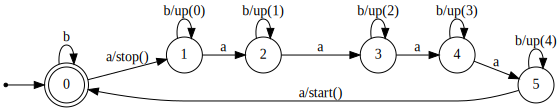

In [7]:
figklok = !echo '{digraphklok}' | dot -Tsvg 
display(SVG('\n'.join(figklok)))

In [8]:
!echo '{digraphklok}' | dot -Tpng > klok-automaat.png

```Python

def up(col):
    if col == 0:
        hours = (hours + 1) % 24
    elif col == 1:
        minutes = (minutes + 10) % 60
    elif col == 2:
        minutes = (minutes + 1) % 10
    elif col == 3:
        seconds = (seconds + 10) % 60
    elif col == 4:
        seconds = (seconds + 1) % 10

state = 0
running = False

def stop():
    global running
    running = False

def start():
    global running
    running = True
        
def button_a_handler():
    global state
    if state == 0:
        state = 1
        stop()
    elif state == 1:
        state = 2
    elif state == 2:
        state = 3
    elif state == 3:
        state = 4
    elif state == 4:
        state = 5
    elif state == 5:
        state = 0
        start()
   
def button_b_handler():
    global state
    up(state-1)
    
hours, minutes, seconds = 0, 0, 0
display_time()
start()
while True:
    if running and (utime.ticks_ms() % 1000 == 0):
        next_second()
    if button_a.was_pressed():
        button_a_handler()
    if button_b.was_pressed():
        button_b_handler()
    sleep(10)
```

```
def button_a_handler():
    if state == 0:
        stop()
    elif state == 5:
        start()
    state = (state + 1) % 5
```

```Python
# Imports go at the top
from microbit import *
from time import ticks_ms, ticks_add, ticks_diff

hours, minutes, seconds = 0, 0, 0

def display_binary(col, nr):
    for i in range(5):
        display.set_pixel(col, 4-i, 9 *(nr % 2) )
        nr = nr // 2

def display_time():
    print('display_time')
    global hours, minutes, seconds 
    display_binary(4, seconds % 10)
    display_binary(3, seconds // 10)
    display_binary(2, minutes % 10)
    display_binary(1, minutes // 10)
    display_binary(0, hours)

def next_second():
    global hours, minutes, seconds
    seconds = seconds + 1
    if seconds == 60:
        seconds = 0
        minutes = minutes + 1
        if minutes == 60:
            minutes = 0
            hours = (hours + 1) % 24
    display_time()

def up_lastdigit(num):
    return (num // 10) * 10 + (num + 1) % 10

def up(col):
    global hours, minutes, seconds
    if col == 0:
        hours = (hours + 1) % 24
        print('hours: {}'.format(hours))
    elif col == 1:
        minutes = (minutes + 10) % 60
    elif col == 2:   
        minutes = up_lastdigit(minutes)
    elif col == 3:
        seconds = (seconds + 10) % 60
    elif col == 4:
        seconds = up_lastdigit(seconds)
    display_time()     

state = 0
running = False

def stop():
    global running
    running = False

def start():
    global running, deadline
    running = True
    deadline = ticks_add(deadline, 1000)
        
def button_a_handler():
    global state
    if state == 0:
        state = 1
        stop()
    elif state == 1:
        state = 2
    elif state == 2:
        state = 3
    elif state == 3:
        state = 4
    elif state == 4:
        state = 5
    elif state == 5:
        state = 0
        start()
   
def button_b_handler():
    global state
    up(state-1)

deadline = ticks_ms()   # now
hours, minutes, seconds = 0, 0, 0
blink = False
display_time()
start()
while True:
    if ticks_diff(ticks_ms(), deadline) > 0:
        if running:
            next_second()
            deadline = ticks_add(deadline, 1000)
        else:
            if blink:
                display.set_pixel(state-1, 0, 9)
            else:
                display.set_pixel(state-1, 0, 0)
            blink = not blink
            deadline = ticks_add(deadline, 200)
    if button_a.was_pressed():
        button_a_handler()
    if button_b.was_pressed():
        button_b_handler()
    sleep(10)
```